In [1]:
import numpy as np
import pImpactR as impact
import matplotlib.pyplot as plt
import scipy
int = np.vectorize(int)
cmap = plt.get_cmap('rainbow')

(0, 1)

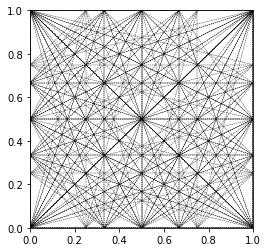

In [2]:
def resonnace(ix,iy,N):
    if ix==0 and iy==0:
        nux=0
        nuy=0
    else:
        if ix==0:
            nux = np.linspace(-1,1,2)
            nuy = np.linspace(float( N )/iy, float( N )/iy, 2)
        elif iy==0:
            nuy = np.linspace(-1,1,2)
            nux = np.linspace(float( N )/ix, float( N )/ix, 2)
        else:        
            nux = np.linspace(-1,1,2)
            nuy = ix/float(iy)*nux +  N/float(iy)
    return nux,nuy


plt.figure(figsize=(4,4))
for i in range(-4,4):
    for j in range(-4,4):
        for k in range(-4,4):
            nux,nuy = resonnace(i,j,k)
            plt.plot(nux,nuy,c='k',lw=0.4,ls='--')

plt.xlim((0,1))
plt.ylim((0,1))

In [3]:
beam, lattice = impact.readInputFile('test_IOTA.in')
ke   = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency
betx = 1.9065054393933862
alfx = 1.408226172730429
Nturn = np.array([128,256,512,1024,2048])
ChaosPercent = 99.0
iTBT = {}
TBT = {}
TBT_Inv = {}
X = {}
Y = {}
Npt = {}

NL_c = lattice[3].transverse_scale_c
x0 = betx**0.5*NL_c
x0 = np.array([-x0,x0])
y0 = [0,0]

reading ImpactZ input file (test_IOTA.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [4]:
def getClosestDiff(ref,arr):
    # ref.shape = nSample
    nMode = len(arr)
    if ref>1.0:
        ref = ref - 1.0
    for i in range(nMode):
        if arr[i]>1.0:
            arr[i]=arr[i]-1.0
    diff = np.abs(ref-arr)
    for i in range(nMode):
        if (diff[i]>0.5):
            diff[i] = 1.0 - diff[i]
    return np.min(diff)

In [5]:
for nturn in Nturn:
    iTBT[nturn],TBT[nturn] = impact.readTBT(nturn,ke,mass,freq)
    Npt[nturn] = len(iTBT[nturn])
    
pData = impact.readParticleData(-111110,ke,mass,freq)
dist = scipy.stats.gaussian_kde(pData[:,[0,2]].transpose())

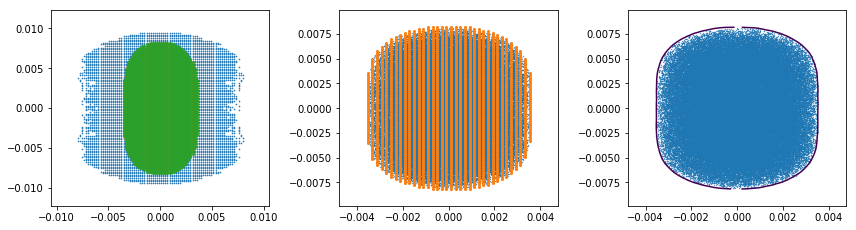

In [6]:
n0 = Nturn[0]
weight = dist([TBT[n0][0,0,:],TBT[n0][0,2,:]])
iCore = np.argwhere(weight > 500) # empirically found ...
iCore = iTBT[n0][iCore]

iCoreTmp = np.in1d(iTBT[n0],iCore)
xTmp = TBT[n0][0,0,iCoreTmp]
yTmp = TBT[n0][0,2,iCoreTmp]

grid = impact.data.dictClass()
grid.extent = [xTmp.min(),xTmp.max(),yTmp.min(),yTmp.max()]
grid.x, grid.y = np.mgrid[xTmp.min():xTmp.max():64j, yTmp.min():yTmp.max():64j]
grid.points = np.vstack([grid.x.ravel(), grid.y.ravel()])
grid.z = np.reshape(dist(grid.points).T, grid.x.shape)

plt.figure(figsize=(12,3.3))
plt.subplot(1,3,1)
plt.scatter(TBT[n0][0,0,:],TBT[n0][0,2,:],s=0.4)
plt.scatter(pData[::10,0],pData[::10,2],s=0.1)
plt.scatter(xTmp,yTmp,s=4.0)
plt.subplot(1,3,2)
plt.scatter(pData[::10,0],pData[::10,2],s=0.1)
plt.scatter(xTmp,yTmp,s=4.0)
plt.subplot(1,3,3)
plt.scatter(pData[::10,0],pData[::10,2],s=0.1)
plt.contour(grid.z.T, extent=grid.extent, levels=[800]);
plt.tight_layout()

# pData = None
# dist = None
# weight = None

In [7]:
X = {}
Y = {}

for n in range(len(Nturn)):
    nturn = Nturn[n]
    iCoreNow = np.in1d(iTBT[nturn],iCore)
    nptCore  = np.count_nonzero(iCoreNow)
    
    X[nturn]=np.zeros((nturn,nptCore),dtype=np.complex)
    Y[nturn]=np.zeros((nturn,nptCore),dtype=np.complex)
    
    for m in range(n+1):
        mturn = Nturn[m]
        if m>0:
            iturn = Nturn[m-1]
        else:
            iturn = 0
        print(iturn,mturn,nturn)    
        iCoreNow = np.in1d(iTBT[mturn],iCore)
        #print(n,m,nptCore,np.count_nonzero(iCoreNow))
        X[nturn][iturn:mturn,:] = TBT[mturn][:,0,iCoreNow] - 1j*TBT[mturn][:,1,iCoreNow]
        Y[nturn][iturn:mturn,:] = TBT[mturn][:,2,iCoreNow] - 1j*TBT[mturn][:,3,iCoreNow]
        
# iTBTF = None
# iTBTB = None
# TBTB = None
# TBTF = None

0 128 128
0 128 256
128 256 256
0 128 512
128 256 512
256 512 512
0 128 1024
128 256 1024
256 512 1024
512 1024 1024
0 128 2048
128 256 2048
256 512 2048
512 1024 2048
1024 2048 2048


In [8]:
iMax = {}
iMin = {}
tuneXbefore= {}
tuneYbefore= {}
Xdiff = {}
Ydiff = {}
Adiff = {}
XdiffLog = {}
YdiffLog = {}
AdiffLog = {}
XdiffSig = {}
YdiffSig = {}
AdiffSig = {}

for nturn in Nturn[1:]:
    npt = len(X[nturn][0,:])
    tuneXbefore[nturn] = np.zeros(npt)
    tuneYbefore[nturn] = np.zeros(npt)
    Xdiff[nturn] = np.zeros(npt)
    Ydiff[nturn] = np.zeros(npt)
    Adiff[nturn] = np.zeros(npt)
    for i in range(npt):
        tuneXbefore[nturn][i],amp,dummy = impact.util.naff(1,X[nturn][:int(nturn/2),i],window_id=1)
        tune,amp,dummy = impact.util.naff(3,X[nturn][int(nturn/2):,i],window_id=1)
        Xdiff[nturn][i] = getClosestDiff(tuneXbefore[nturn][i],tune)
        tuneYbefore[nturn][i],amp,dummy = impact.util.naff(1,Y[nturn][:int(nturn/2),i],window_id=1)
        tune,amp,dummy = impact.util.naff(3,Y[nturn][int(nturn/2):,i],window_id=1)
        Ydiff[nturn][i] = getClosestDiff(tuneYbefore[nturn][i],tune)
    Adiff[nturn] = np.sqrt(Xdiff[nturn]**2 +Ydiff[nturn]**2)
    AdiffLog[nturn] = np.log10(Adiff[nturn]+1.0e-6)
    XdiffLog[nturn] = np.log10(Xdiff[nturn]+1.0e-6)
    YdiffLog[nturn] = np.log10(Ydiff[nturn]+1.0e-6)
    AdiffSig[nturn] = 1.0/(1.0+np.exp(-AdiffLog[nturn]+np.percentile(AdiffLog[nturn],ChaosPercent)))
    XdiffSig[nturn] = 1.0/(1.0+np.exp(-XdiffLog[nturn]+np.percentile(XdiffLog[nturn],ChaosPercent)))
    YdiffSig[nturn] = 1.0/(1.0+np.exp(-YdiffLog[nturn]+np.percentile(YdiffLog[nturn],ChaosPercent)))
    iMax[nturn] = np.argmax(Adiff[nturn]),np.argmax(Xdiff[nturn]),np.argmax(Ydiff[nturn])
    iMin[nturn] = np.argmin(Adiff[nturn]),np.argmin(Xdiff[nturn]),np.argmin(Ydiff[nturn])

In [9]:
test=np.sort(Adiff[1024])
print(test[-int(len(Adiff[1024])*0.01):])

[0.00175135 0.00175179 0.00175635 0.001758   0.00180083 0.001823
 0.00182392 0.00187628 0.00188518 0.00190313 0.0019063  0.00192401
 0.00222355 0.00224448 0.00227024 0.0023602  0.00247935 0.00263548
 0.00276002 0.00374946 0.00376926 0.00383983 0.00441647 0.00614534
 0.00946525]


# plot

### FFT

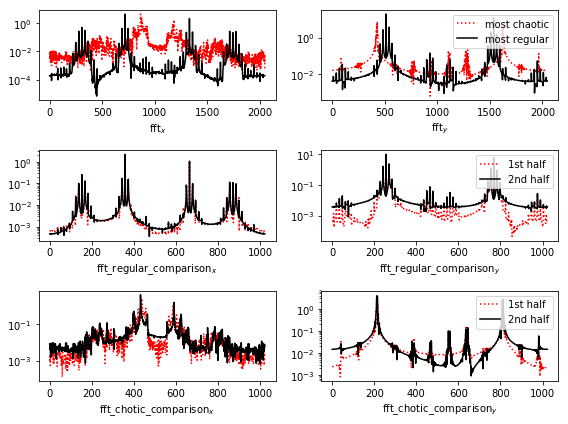

In [10]:
n=2048
plt.figure(figsize=[8,6])
plt.subplot(3,2,1)
plt.semilogy(np.abs(np.fft.fft(X[n][:,iMax[n][1]])),'r:')
plt.semilogy(np.abs(np.fft.fft(X[n][:,iMin[n][1]])),'k')
plt.xlabel('fft$_x$')
plt.subplot(3,2,2)
plt.semilogy(np.abs(np.fft.fft(Y[n][:,iMax[n][2]])),'r:')
plt.semilogy(np.abs(np.fft.fft(Y[n][:,iMin[n][2]])),'k')
plt.legend(['most chaotic','most regular'],loc=1)
plt.xlabel('fft$_y$')
plt.subplot(3,2,3)
plt.semilogy(np.abs(np.fft.fft(X[n][:1024,iMin[n][1]])),'r:')
plt.semilogy(np.abs(np.fft.fft(X[n][1024:,iMin[n][1]])),'k')
plt.xlabel('fft_regular_comparison$_x$')
plt.subplot(3,2,4)
plt.semilogy(np.abs(np.fft.fft(Y[n][:1024,iMin[n][2]])),'r:')
plt.semilogy(np.abs(np.fft.fft(Y[n][1024:,iMin[n][2]])),'k')
plt.xlabel('fft_regular_comparison$_y$')
plt.legend(['1st half','2nd half'],loc=1)
plt.subplot(3,2,5)
plt.semilogy(np.abs(np.fft.fft(X[n][:1024,iMax[n][1]])),'r:')
plt.semilogy(np.abs(np.fft.fft(X[n][1024:,iMax[n][1]])),'k')
plt.xlabel('fft_chotic_comparison$_x$')
plt.subplot(3,2,6)
plt.semilogy(np.abs(np.fft.fft(Y[n][:1024,iMax[n][2]])),'r:')
plt.semilogy(np.abs(np.fft.fft(Y[n][1024:,iMax[n][2]])),'k')
plt.xlabel('fft_chotic_comparison$_y$')
plt.legend(['1st half','2nd half'],loc=1)
plt.tight_layout()
plt.savefig('FMA.FFT.png',dpi=180)
# plt.close()

### tune plot

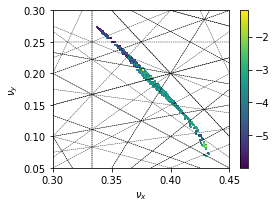

In [11]:
plt.figure(figsize=[4,3])
for i in range(-4,4):
    for j in range(-4,4):
        for k in range(-4,4):
            nux,nuy = resonnace(i,j,k)
            plt.plot(nux,nuy,c='k',lw=0.4,ls='--')
f1=plt.scatter(tuneXbefore[n],tuneYbefore[n],c=AdiffLog[n],s=1.0,marker='s')
    
plt.xlabel(r'$\nu_x$')
plt.ylabel(r'$\nu_y$')
plt.colorbar(f1)
plt.xlim(0.3,0.45)
plt.ylim(0.05,0.3)
plt.tight_layout()
plt.savefig('FMA.tune.A.png',dpi=180)
# plt.close()

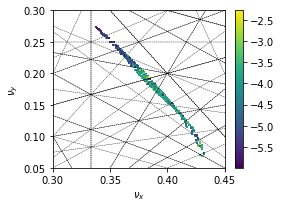

In [12]:
plt.figure(figsize=[4,3])
for i in range(-4,4):
    for j in range(-4,4):
        for k in range(-4,4):
            nux,nuy = resonnace(i,j,k)
            plt.plot(nux,nuy,c='k',lw=0.4,ls='--')
f1=plt.scatter(tuneXbefore[n],tuneYbefore[n],c=XdiffLog[n],s=1.0,marker='s')
plt.xlabel(r'$\nu_x$')
plt.ylabel(r'$\nu_y$')
plt.colorbar(f1)
plt.xlim(0.3,0.45)
plt.ylim(0.05,0.3)
plt.tight_layout()
plt.savefig('FMA.tune.X.png',dpi=180)
# plt.close()

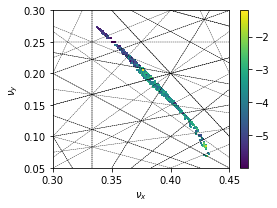

In [13]:
plt.figure(figsize=[4,3])
for i in range(-4,4):
    for j in range(-4,4):
        for k in range(-4,4):
            nux,nuy = resonnace(i,j,k)
            plt.plot(nux,nuy,c='k',lw=0.4,ls='--')
f1=plt.scatter(tuneXbefore[n],tuneYbefore[n],c=YdiffLog[n],s=1.0,marker='s')
plt.xlabel(r'$\nu_x$')
plt.ylabel(r'$\nu_y$')
plt.colorbar(f1)
plt.xlim(0.3,0.45)
plt.ylim(0.05,0.3)
plt.tight_layout()
plt.savefig('FMA.tune.Y.png',dpi=180)
# plt.close()

### Poincare

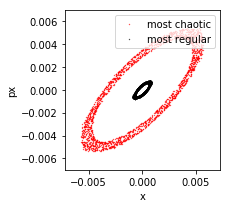

In [13]:
plt.figure(figsize=[3.3,3])
plt.scatter(np.real(X[n][:,iMax[n][0]]),np.imag(X[n][:,iMax[n][0]]),c='r',s=0.1)
plt.scatter(np.real(X[n][:,iMin[n][0]]),np.imag(X[n][:,iMin[n][0]]),c='k',s=0.1)
plt.xlabel('x')
plt.ylabel('px')
plt.legend(['most chaotic','most regular'],loc=1)
plt.tight_layout()
plt.savefig('FMA.Poincare.A.png',dpi=180)

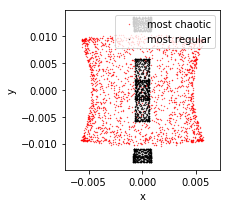

In [14]:
plt.figure(figsize=[3.3,3])
plt.scatter(np.real(X[n][:,iMax[n][0]]),np.real(Y[n][:,iMax[n][0]]),c='r',s=0.1)
plt.scatter(np.real(X[n][:,iMin[n][0]]),np.real(Y[n][:,iMin[n][0]]),c='k',s=0.1)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['most chaotic','most regular'],loc=1)
plt.tight_layout()
plt.savefig('FMA.Poincare.X.png',dpi=180)

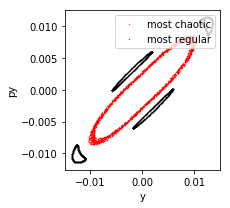

In [15]:
plt.figure(figsize=[3.3,3])
plt.scatter(np.real(Y[n][:,iMax[n][0]]),np.imag(Y[n][:,iMax[n][0]]),c='r',s=0.1)
plt.scatter(np.real(Y[n][:,iMin[n][0]]),np.imag(Y[n][:,iMin[n][0]]),c='k',s=0.1)
plt.xlabel('y')
plt.ylabel('py')
plt.legend(['most chaotic','most regular'],loc=1)
plt.tight_layout()
plt.savefig('FMA.Poincare.Y.png',dpi=180)

### Dynamic Aperture (Abs)

In [60]:
for n in Nturn:
    X[n]=X[n]*1.0e3
    Y[n]=Y[n]*1.0e3
x0 = x0*1.0e3

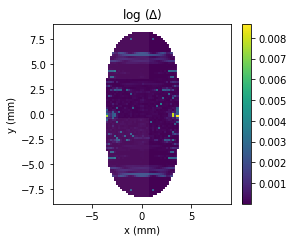

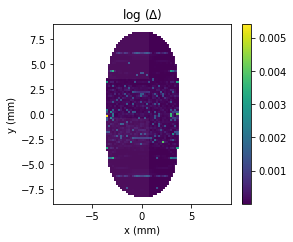

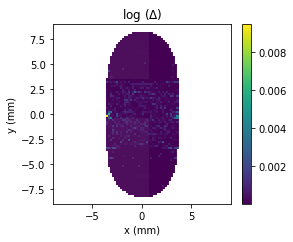

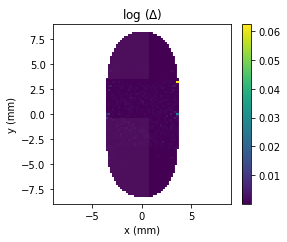

In [61]:
xmax = np.max([np.real(X[n][0,:]),np.real(Y[n][0,:])])
for n in Nturn[1:]:
    plt.figure(figsize=[4,3.3])
    f1=plt.scatter(np.real(X[n][0,:]),np.real(Y[n][0,:]),c=Adiff[n],s=1.6,marker='s')
#     plt.scatter(np.real(X[n][0,iMax[n][0]]),np.real(Y[n][0,iMax[n][0]]),c='r',s=77,marker='x')
    plt.scatter(x0,y0,c='r',s=77,marker='x')
    plt.xlim(-xmax*1.1,xmax*1.1)
    plt.ylim(-xmax*1.1,xmax*1.1)
    plt.xlabel('x (mm)')
    plt.ylabel('y (mm)')
    plt.title(r'log ($\Delta$)')
    plt.colorbar(f1)
    plt.savefig('FMA.DA.Abs.A.'+str(nturn)+'.png',dpi=180)    

### Dynamic Aperture (Sigmoid)

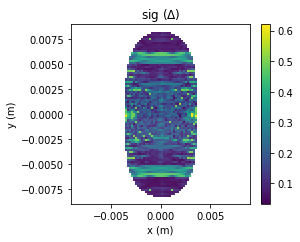

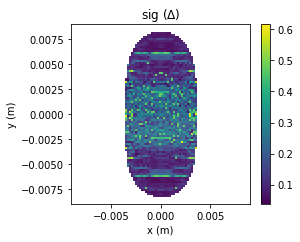

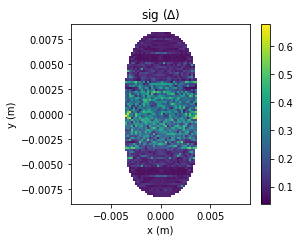

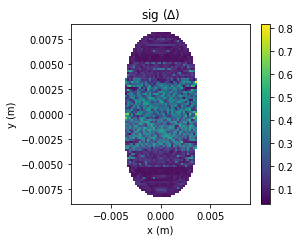

In [17]:
Adiff = AdiffSig
Xdiff = XdiffSig
Ydiff = YdiffSig

for n in Nturn[1:]:
    plt.figure(figsize=[4,3.3])
    f1=plt.scatter(np.real(X[n][0,:]),np.real(Y[n][0,:]),c=Adiff[n],s=1.6,marker='s')
#     plt.scatter(np.real(X[n][0,iMax[n][0]]),np.real(Y[n][0,iMax[n][0]]),c='r',s=77,marker='x')
    plt.scatter(x0,y0,c='r',s=77,marker='x')
    plt.xlim(-xmax*1.1,xmax*1.1)
    plt.ylim(-xmax*1.1,xmax*1.1)
    plt.xlabel('x (mm)')
    plt.ylabel('y (mm)')
    plt.title(r'sig ($\Delta$)')
    plt.colorbar(f1)
    plt.savefig('FMA.DA.Sig.A.'+str(nturn)+'.png',dpi=180)    

### Dynamic Aperture (Log)

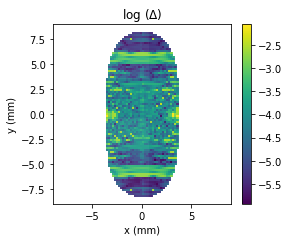

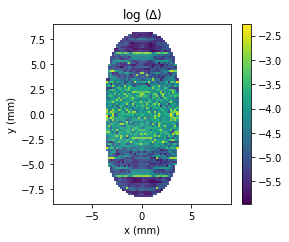

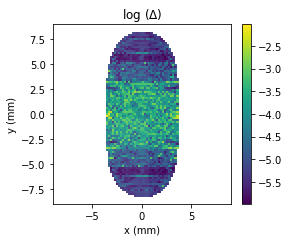

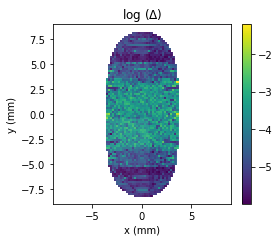

In [62]:
Adiff = AdiffLog
Xdiff = XdiffLog
Ydiff = YdiffLog

for n in Nturn[1:]:
    plt.figure(figsize=[4,3.3])
    f1=plt.scatter(np.real(X[n][0,:]),np.real(Y[n][0,:]),c=Adiff[n],s=1.6,marker='s')
#     plt.scatter(np.real(X[n][0,iMax[n][0]]),np.real(Y[n][0,iMax[n][0]]),c='r',s=77,marker='x')
    plt.scatter(x0,y0,c='r',s=77,marker='x')
    plt.xlim(-xmax*1.1,xmax*1.1)
    plt.ylim(-xmax*1.1,xmax*1.1)
    plt.xlabel('x (mm)')
    plt.ylabel('y (mm)')
    plt.title(r'log ($\Delta$)')
    plt.colorbar(f1)
    plt.savefig('FMA.DA.Log.A.'+str(nturn)+'.png',dpi=180)    

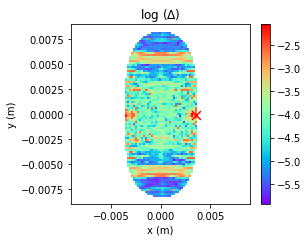

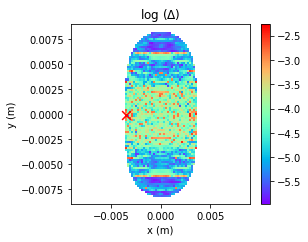

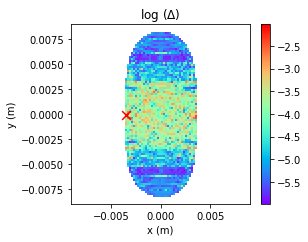

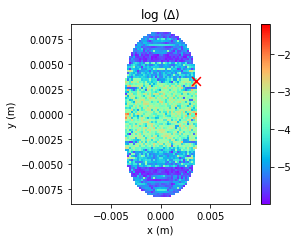

In [19]:
for n in Nturn[1:]:
    plt.figure(figsize=[4,3.3])
    f1=plt.scatter(np.real(X[n][0,:]),np.real(Y[n][0,:]),c=Adiff[n],s=1.6,marker='s',cmap=cmap)
    plt.scatter(np.real(X[n][0,iMax[n][0]]),np.real(Y[n][0,iMax[n][0]]),c='r',s=77,marker='x')
    plt.xlim(-xmax*1.1,xmax*1.1)
    plt.ylim(-xmax*1.1,xmax*1.1)
    plt.xlabel('x (mm)')
    plt.ylabel('y (mm)')
    plt.title(r'log ($\Delta$)')
    plt.colorbar(f1)
    plt.savefig('FMA.DA.Log.A.'+str(nturn)+'.png',dpi=180)    

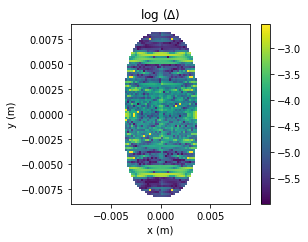

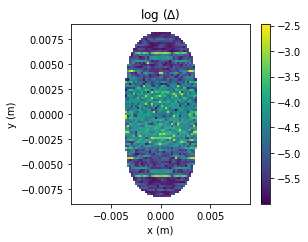

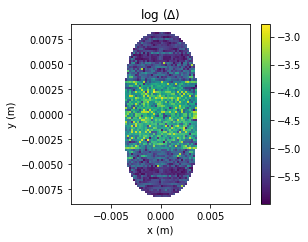

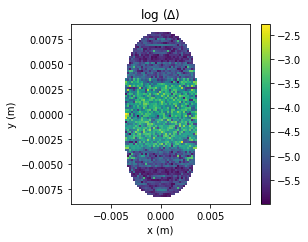

In [20]:
for n in Nturn[1:]:
    plt.figure(figsize=[4,3.3])
    f1=plt.scatter(np.real(X[n][0,:]),np.real(Y[n][0,:]),c=Xdiff[n],s=1.6,marker='s')
#     plt.scatter(np.real(X[n][0,iMax[n][1]]),np.real(Y[n][0,iMax[n][1]]),c='r',s=77,marker='x')
    plt.scatter(x0,y0,c='r',s=77,marker='x')
    plt.xlim(-xmax*1.1,xmax*1.1)
    plt.ylim(-xmax*1.1,xmax*1.1)
    plt.xlabel('x (mm)')
    plt.ylabel('y (mm)')
    plt.title(r'log ($\Delta$)')
    plt.colorbar(f1)
    plt.savefig('FMA.DA.Log.X.'+str(nturn)+'.png',dpi=180)

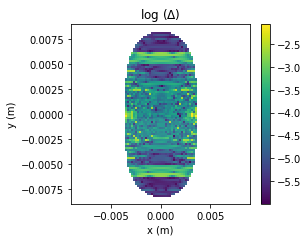

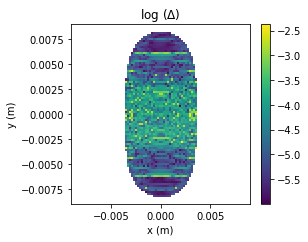

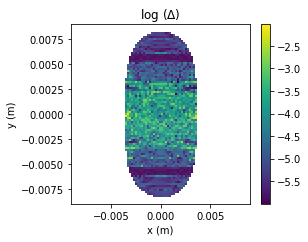

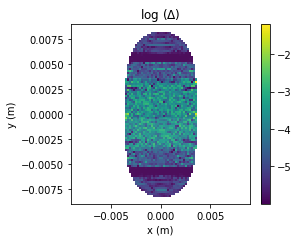

In [21]:
for n in Nturn[1:]:
    plt.figure(figsize=[4,3.3])
    f1=plt.scatter(np.real(X[n][0,:]),np.real(Y[n][0,:]),c=Ydiff[n],s=1.6,marker='s')
#     plt.scatter(np.real(X[n][0,iMax[n][2]]),np.real(Y[n][0,iMax[n][2]]),c='r',s=77,marker='x')
    plt.scatter(x0,y0,c='r',s=77,marker='x')
    plt.xlim(-xmax*1.1,xmax*1.1)
    plt.ylim(-xmax*1.1,xmax*1.1)
    plt.xlabel('x (mm)')
    plt.ylabel('y (mm)')
    plt.title(r'log ($\Delta$)')
    plt.colorbar(f1)
    plt.savefig('FMA.DA.Log.Y.'+str(nturn)+'.png',dpi=180)